# MNIST dataset: a starting-point notebook

In this notebook we will classify examples from the MNIST hand-digit dataset according to different classification methods. The accuracy, precision and recall for each classification method will be determined.

We will use here:
- Logistic regression ("by hand" )
- Random Forest
- Naive Bayes
- Support Vector Machines

Finally we briefly present the result of the principal compnent analysis (PCA), again adopting a "by-hand" aproach.

This notebook might be useful to beginners in ML with Python, but with basic ML knowledge (e.g. linear, polynomial, logistic regression; gradient descent etc.).
Also, optimization techniques are beyond the scope of his notebook, and we mainly use classifier from sklearn with standard parameters.

# Part 1: Import libraries and data + some little EDA

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./input"))

# Any results you write to the current directory are saved as output.

['fashion-mnist_test.csv', 't10k-labels-idx1-ubyte']


In [3]:
#Importing the data as pandas dataframe. We won't use the test.csv file, as we are
#concerned with supervised learning here. We rather divide train.csv into train and test set
#each example then having its own target value known. 

train = pd.read_csv('./input/train.csv')
#test = pd.read_csv('../input/test.csv')

Let us have a look to the "train" data:

In [4]:
train.shape

(42000, 785)

In [5]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We see it is a $n \times m$ matrix, with $n = 42000$ examples (images). Note that the first column 'label' denotes the independent variable column, i.e. the true digit corresponding to the image. 

Each images is then encoded in a $m = 785-1 = 784$ feature vector, representing the intensity of the pixel. Each element of the vector contains an integer encoding the intensity of a pixel. In other words the original image is decomposed in a $28 \times 28$ pixel grid, which is reshaped to be represented as a $ 28 \times 28=784$ column vector.

Let us see below the visual represetation

In [6]:
# We select 5 random examples (rows) from the train dataset
random_indexes = random.sample(range(train.shape[0]),5)

In [7]:
#The original images are obtained by reshaping the rowos
original_images = [np.array(train.iloc[element,1:]).reshape(28,28) for element in random_indexes]

#The 784-dimensional array form is instead
array_representation = [np.array(train.iloc[element,1:]) for element in random_indexes]

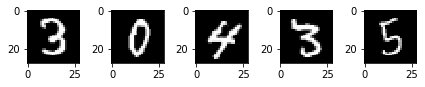

In [8]:
#Visualizing the orginal images
fig, axes = plt.subplots(nrows=1, ncols=5)

i=0
for ax in axes:
    ax.imshow(original_images[i], cmap ='gist_gray')
    i +=1
fig.tight_layout()

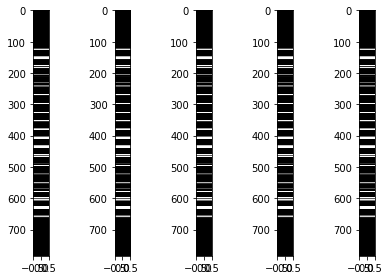

In [9]:
#Visualizing their 784-dimensional array form

fig, axes = plt.subplots(nrows=1, ncols=5)

i=0
for ax in axes:
    ax.imshow(array_representation[0].reshape(784,1), aspect = 0.02,  cmap='gist_gray')
    i +=1
fig.tight_layout()

Let us have a look of the general statistical properties of the matrix 'train'. Many pixels have intensity 0, as it is expected: those correspond to the regions at border of the paper where the digit is originally drawn, which are less likely to be filled.

In [10]:
train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


The most likely pixel to contain part of the hand-written digit is 

In [11]:
train.describe().loc['mean'].idxmax()

'pixel407'

That is, this guy

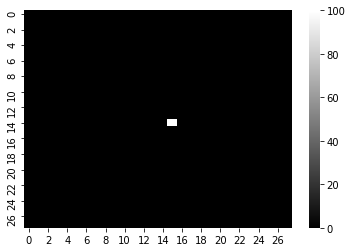

In [12]:
temp_im = np.zeros(shape=(28,28))
temp_im[407//28, 407%28] = 100

sns.heatmap(temp_im, cmap ='gray')
plt.show()

#### Question: What's the most frequent digit present in the train set?

We see it's number 1. What would we expect? Well, each person who took part to the MNIST experiment had equal probability of writing a digit between 0-9. In practice, some cultural factor might influence their choice. For instance, number one is associated to succes, number 3 to perfection, whereas number 0 might not be so appealing... So if naively one expcets a uniform probability mass distribution for the 0-9 digits, it is not obvious what is going to happen in the infinite-example limit $n -> \infty$.

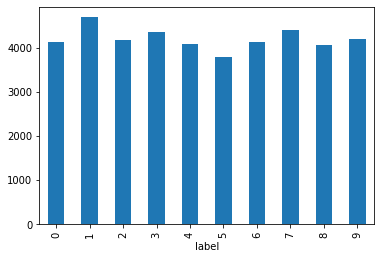

In [13]:
train.groupby('label').pixel0.count().plot.bar()
plt.show()

### Finally we define few functions for later convenience

In [14]:
#Normalizes each pixel column [-1,1], taking into account that some column is completely filed with 0s
def feat_normalize(X):
    M = X.shape[1]
    for i in range(M):
        if np.any(X[:,i]) != 0:
            min_ = X[:,i].min()
            max_ = X[:,i].max()
            X[:,i] =(2*X[:,i]-min_-max_)/(max_-min_)
            

            
def append_ones(X):
    
    s = X.shape[0]
    
    ones = np.ones(shape=(s,1))
    
    return np.concatenate((ones, X), axis=1)

            
#functions to calculate precision, recall and F1 score of a model
            

def prec_rec_F1(class_rep):
    precision = []
    recall = []
    F1 = []

    for i in range(10):
        temp = np.zeros(shape=(2,2))
        temp[0,0] = class_rep.iloc[i,i]
        temp[0,1] = sum(class_rep.iloc[i,:i]) + sum(class_rep.iloc[i,i+1:])
        temp[1,0] = sum(class_rep.iloc[:i,i]) + sum(class_rep.iloc[i+1:, i])
        temp[1,1] = sum(np.diag(class_rep))- class_rep.iloc[i,i]
    
        ptemp = temp[0,0]/(temp[0,0]+ temp[0,1])
        precision.append([i,ptemp])
        rectemp = temp[0,0]/(temp[0,0]+ temp[1,0])
        recall.append([i,rectemp])
        F1.append([i,2 * ptemp * rectemp /(ptemp+rectemp)])
    
    return [precision, recall, F1]

def create_class_rep(prediction, y_test):
    class_rep =np.zeros(shape=(10,10))
    
    for i in range(len(y_test)):
        x = prediction[i]
        y = y_test[i]
        class_rep[x,y] +=1
        
    class_rep = pd.DataFrame(class_rep)
    return class_rep.applymap(int)





# Part 2: classifying the dataset

## First approach: logistic regression by hand

We use here the one vs all classification for multiclass problem: 
- take an example ex
- Consider one of the ten classes an example can be classified into (i.e. class = 3)
- Get the probabilities for ex to belong to class 3 or not by solving a binary classification model
- Repeat for each of the ten classes
- Classify ex -> class =... according to the highest obtained probability

Let us define few functions:

In [15]:
#Sigmoid function
def sigmoid(x):
    return 1/(1 + np.exp(-x))

#Cost function of the logistic regression for binary classification, s_i = {0,1} 
def cost(X, y , theta):
    dim = X.shape[0]
    s = sigmoid(np.dot(X,theta))
    tot = -(np.log(s)*y +np.log(1-s)*(1-y))
    return 1/dim *sum(tot)[0]
    
#Gradient of the cost function with respect to the parameters theta. To be used in gradient descent below
def grad_cost(X, y, theta):
    
    dim = X.shape[0]
    pred = sigmoid(np.dot(X,theta))
    c1 = 1/dim * np.transpose(pred-y)
    return np.transpose(np.dot(c1,X))

#Gradient descent to get the parameter theta
def grad_descent(X, y, theta, learning_par, num_iter):

    for i in range(num_iter):
        #print cost(X,y,theta) to check the cost is monotonically decreasing at each iteration
        theta = theta - learning_par*grad_cost(X,y,theta)
        
    return theta





In [16]:
#Dividing the training set in train and test set

y = train.iloc[:,0]
X = train.iloc[:,1:]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 101)

#Normalizing the train and test sets
X_train = np.array(X_train)
feat_normalize(X_train)
X_train = append_ones(X_train)


#Appending the bias column to the train and test matrices

X_test = np.array(X_test)
feat_normalize(X_test)
X_test = append_ones(X_test)






Now we can apply the on vs all classification. For each category 0-9 we get the list of target indexes and train the model to classfify whether an example belongs to that category or not, with the respective probability.

Each binary classification is trained by minimizing the cost function via gradient descent

In [17]:
#Create the vector of target lables for each digit 0-9
y_target = []
for i in range(10):
    y_target.append(y_train.apply(lambda x: 1 if x == i else 0))
    
#Initialize the list of training parameters (784+1 (bias) for each digit)
theta=[]

#Gradient descent to train the model
for i in range(10):
    ytemp = np.array(y_target[i])
    ytemp = ytemp.reshape(y_train.shape[0],1)

    thetatemp = np.zeros(shape=(X_train.shape[1],1))

    alpha = 0.03
    n_iter = 100

    thetatemp = grad_descent(X_train,ytemp,thetatemp,alpha,n_iter)
    theta.append(thetatemp)
    print('{}: done!'.format(i))

0: done!
1: done!
2: done!
3: done!
4: done!
5: done!
6: done!
7: done!
8: done!
9: done!


Great, we're all set! We have determined a form for 10 785-dimensional vectors theta[i] which we use to classify new examples. For instance, theta[0] and theta[1] are found as the following (in image form):

In [ ]:
plt.imshow(theta[0][1:].reshape(28,28), cmap='gist_gray')
plt.show()

In [ ]:
plt.imshow(theta[1][1:].reshape(28,28), cmap='gist_gray')
plt.show()

Classification is nothing but measuring the overlap of new examples with those "templates" theta. This overlap is then passed to the sigmoid function, which in turns yields an output between 1 (perfect overlap) and 0 (no overlap at all). So the larger the overlap of a new unseen example with one of those templates, the larger the probability the example corresponds to the digit the tempalte is representative of.

#### Let us predict new observation now

In [ ]:
result = [sigmoid(np.dot(X_test,theta[i])) for i in range(10)]
result = np.transpose(np.array(result)).reshape(X_test.shape[0],10)

prediction = (np.array([element.argmax() for element in result])).reshape(X_test.shape[0],1)

We can now test the accuracy of the prediction

In [ ]:
#testing accuracy of the prediction
y_test = np.array(y_test)
y_test = y_test.reshape(y_test.shape[0],1)


accuracy = sum(prediction == y_test)[0]/(y_test.shape[0])
print('Accuracy is: {}%'.format(accuracy))

 We find an accuracy of ~82%, which can be improved by tuning the number of iterations and the learning parameter in the gradient descent loop.

#### We create a classification matrix

That is a matrix summarizing the classification for each example:  

In [ ]:
class_rep = create_class_rep(prediction,y_test)
class_rep

For instance the first row is telling us that out of (1257+0+3+13+4+8+21+0+22+1)=1329 examples containing the digit "0", 1257 have been correctly classfied, 0 of them have been classified as "1", 3 as "2", etc. 


From the matrix above we can calculate the precision, recall and F1 score of our model

In [ ]:
precision, recall, F1 = prec_rec_F1(class_rep)

We can plot the obtained result for each class

In [ ]:
plt.figure(figsize=(8,8))

plt.xticks(range(10))
plt.yticks(1/10*np.array(range(10)))

plt.bar(np.transpose(precision)[0],np.transpose(precision)[1], align='edge', width =-0.25)
plt.bar(np.transpose(recall)[0],np.transpose(recall)[1],align='center',width = 0.25)
plt.bar(np.transpose(F1)[0],np.transpose(F1)[1],align='edge',width =0.25)
plt.legend(labels = ('Precision','Recall','F1'))

plt.tight_layout()

## Second approach: Random Forest

Here we classify the new examples according the Random Forest algorithm.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Create a forest with n=100 trees and fot to the model
forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_train, y_train)

In [ ]:
#Predicting new results
prediction = forest.predict(X_test)
prediction = prediction.reshape(prediction.shape[0],1)

In [ ]:
#Accuracy
accuracy = sum(prediction == y_test)[0]/(y_test.shape[0])
print('Accuracy is: {}%'.format(accuracy))

In [ ]:
#Classification report
class_rep = create_class_rep(prediction,y_test)
class_rep

In [ ]:
#And precision, recall, F1

precision, recall, F1 = prec_rec_F1(class_rep)

plt.xticks(range(10))
plt.yticks(1/10*np.array(range(10)))

plt.bar(np.transpose(precision)[0],np.transpose(precision)[1], align='edge', width =-0.25)
plt.bar(np.transpose(recall)[0],np.transpose(recall)[1],align='center',width = 0.25)
plt.bar(np.transpose(F1)[0],np.transpose(F1)[1],align='edge',width =0.25)
plt.legend(labels = ('Precision','Recall','F1'))

plt.tight_layout()



## Third approach: Naive Bayes

We use here the naive Bayes algorithm

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
#Create an instance of the NB algorothm and fit to the training set
classifier = GaussianNB()
classifier.fit(X_test,y_test)

In [ ]:
#Predicting new results
prediction = classifier.predict(X_test)
prediction = prediction.reshape(prediction.shape[0],1)

In [ ]:
accuracy = sum(prediction == y_test)[0]/(y_test.shape[0])
print('Accuracy is: {}%'.format(accuracy))

Accuracy is extremely low as compared to what obtained above. It can of course be improved by some optimization technique (beyond the scope of this notebook).

In [ ]:
#Classification report
class_rep = create_class_rep(prediction,y_test)
class_rep

Where is this low accuracy coming from? Let's see:

In [ ]:
#Number of examples for each class
class_rep['sum'] = class_rep.sum()

#correctly classified examples for each class
diag = pd.Series([class_rep.iloc[i,i] for i in range(10)])

#Misclassification rate
class_rep['misclass_rate'] = 1 - diag / class_rep['sum'] 

class_rep.drop('sum', axis=1)

We see that the most misclassfied example is "5" (95% misclassification rate). 

In [ ]:
#And precision, recall, F1

precision, recall, F1 = prec_rec_F1(class_rep)

plt.xticks(range(10))
plt.yticks(1/10*np.array(range(10)))

plt.bar(np.transpose(precision)[0],np.transpose(precision)[1], align='edge', width =-0.25)
plt.bar(np.transpose(recall)[0],np.transpose(recall)[1],align='center',width = 0.25)
plt.bar(np.transpose(F1)[0],np.transpose(F1)[1],align='edge',width =0.25)
plt.legend(labels = ('Precision','Recall','F1'))

plt.tight_layout()




## Fourth approach: Support Vector Machine

Let us now turn to the support vector machine case.

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
#Create an instance of SVM and cfit to the training set
classifier = LinearSVC()
classifier.fit(X_train, y_train)

In [ ]:
#Predicting
prediction = classifier.predict(X_test)
prediction = prediction.reshape(prediction.shape[0],1)

In [ ]:
#Accuracy
accuracy = sum(prediction == y_test)[0]/(y_test.shape[0])
print('Accuracy is: {}%'.format(accuracy))

In [ ]:
class_rep = create_class_rep(prediction,y_test)
class_rep

In [ ]:
#And precision, recall, F1

precision, recall, F1 = prec_rec_F1(class_rep)

plt.xticks(range(10))
plt.yticks(1/10*np.array(range(10)))

plt.bar(np.transpose(precision)[0],np.transpose(precision)[1], align='edge', width =-0.25)
plt.bar(np.transpose(recall)[0],np.transpose(recall)[1],align='center',width = 0.25)
plt.bar(np.transpose(F1)[0],np.transpose(F1)[1],align='edge',width =0.25)
plt.legend(labels = ('Precision','Recall','F1'))

plt.tight_layout()



# Part 3 / Appendix: Principal component analysis

As we have briefly discussed above, most of the pixels have average value ~0, mainly corresponding to the border areas of the original papers where the digits were drawn. This suggests that the 784+1-dimensional vector of features can be reduced, as to account for the dominant components while neglecting those which are not playing a crucial role in the classification. 


To achieve that, we use Principal Component Analysis. What we do is basically look for correlation between the pixels. For instance pixels 407 and 380:


In [ ]:
temp_im = np.zeros(shape=(28,28))
temp_im[407//28, 407%28] = 100
temp_im[380//28, 380%28] = 100

sns.heatmap(temp_im, cmap ='gray')
plt.show()


are most likely highly correlated, in that when drawing a digit, one that hits pixel 380 is likely to hit also pixel 407. We show below a by-hand derivation, although a similar approach can be adopted by making use of PCA from sklearn.decomposition

In [ ]:
#Calculating the covariance matrix, its eigenvalues and eigenvectors
X_train_trans = np.transpose(X_train)
covariance = np.dot(X_train_trans,X_train)
eigenval, eigenvec = np.linalg.eig(covariance)

In [ ]:
#We pick the first two main eigenvectors. This comes with some advantage concerning visualization.
#(note their are sorted in descnding order with respect to their associated eigenvalues).
#Note the imaginary part of the components of those vector is zero.
#We take the real part just not ot get any error in the following
PCA_mat = np.real(eigenvec[:,0:2])

#### What this components actually are?

They are linear combinations of the original 784-dimensional vectors. To viusalize them, let's plot a heatmap, where the contribution of each component is encoded in the intensity of the colour

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(PCA_mat, cmap = 'inferno')
plt.show()

 Now that we have obtained the rotation matrix PCA_mat, we can project the training set along these two main directions

In [ ]:
X_transf = np.dot(X_train, PCA_mat)

We can visualize the data. Each colour if a datapoint corresponds to a class. We see it's very hard to distinguish the different clusters. This suggests that by retaining only 2 principal compenents we are losing some substantial amount of information

In [ ]:
plt.scatter(X_transf[:,0],X_transf[:,1], c = y_train, cmap ='plasma')
plt.show()

 To verify this, let us run a standard logistic regression classification

In [ ]:
y_target = []
for i in range(10):
    y_target.append(y_train.apply(lambda x: 1 if x == i else 0))
    
#Initialize the list of training parameters (784+1 (bias) for each digit)
theta=[]

#Gradient descent to train the model
for i in range(10):
    ytemp = np.array(y_target[i])
    ytemp = ytemp.reshape(y_train.shape[0],1)

    thetatemp = np.zeros(shape=(X_transf.shape[1],1))

    alpha = 0.03
    n_iter = 400

    thetatemp = grad_descent(X_transf,ytemp,thetatemp,alpha,n_iter)
    theta.append(thetatemp)
    print('{}: done!'.format(i))

Transforming the test set as well, and testing the accuracy of the model, we in fact realize the prediction are not optimal...Accuracy ~29%! 

In [ ]:
X_test_transf = np.dot(X_test, PCA_mat)

In [ ]:
result = [sigmoid(np.dot(X_test_transf,theta[i])) for i in range(10)]
result = np.transpose(np.array(result)).reshape(X_test.shape[0],10)

prediction = (np.array([element.argmax() for element in result])).reshape(X_test_transf.shape[0],1)

In [ ]:
y_test = np.array(y_test)
y_test = y_test.reshape(y_test.shape[0],1)


accuracy = sum(prediction == y_test)[0]/(y_test.shape[0])
print('Accuracy is: {}%'.format(accuracy))

How to choose the number of principal component such that a faithful representation of the original dataset is retained? The rule is to preserve '99%' of the variance of the data. A rough way to check this is to compare the cumulative sum of the k-principal eigenvalues against the full $m$ = 785-list of eigenvalues. In particular  we want to check what's the smallest $k$ such that 
 $$ 1- \frac{\sum_{k} \textrm{Eigenvalues}}{\sum_{m} \textrm{Eigenvalues}} \le 0.01 $$

In [ ]:
for k in range(X_train.shape[1]):
    if 1-sum(eigenval[:k])/sum(eigenval) < 0.01:
        print('{} principal components needed'.format(k))
        break
    

Can you verify that by using this number of components the accuracy is actually close to that of the full model?